## Compare Graph Signatures

In [39]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
from scipy.spatial.transform import Rotation

from pygsp import graphs, filters, plotting, reduction
import os.path
from global_graph import GlobalGraph
from wavelet_evaluator import WaveletEvaluator
from config import DebugConfig

%load_ext autoreload
%autoreload 2

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

print(f'\n\nLoading....')

dataroot = '/mnt/data/datasets/fgsp/'
datasets = ['h_floor_pos_rot/']

n_datasets = len(datasets)
opt_signals = []
est_signals = []
opt_trajectory = []
est_trajectory = []
est_raw_trajectory = []
opt_graph_coords = []
opt_graph_adj = []
est_graph_coords = []
est_graph_adj = []
for ds in datasets:
    ds_path = dataroot + ds
    print(f'Loading data from {ds_path}')
    opt_signal_path = ds_path + 'opt_signal.npy'
    opt_traj_path = ds_path + 'opt_trajectory.npy'
    est_signal_path = ds_path + 'est_signal.npy'
    est_traj_path = ds_path + 'est_trajectory.npy'  
    est_raw_traj_path = ds_path + 'est_raw_trajectory.npy'  
    opt_graph_coords_path = ds_path + 'opt_graph_coords.npy'
    opt_graph_adj_path = ds_path + 'opt_graph_adj.npy'
    est_graph_coords_path = ds_path + 'est_graph_coords.npy'
    est_graph_adj_path = ds_path + 'est_graph_adj.npy'
 
    if os.path.isfile(opt_signal_path) and os.path.isfile(est_signal_path):
        opt_signals.append(np.load(opt_signal_path))
        est_signals.append(np.load(est_signal_path))
    else:
        print(f'Signal files are not available:')
        print(f'Opt file: {opt_signal_path}')
        print(f'Est file: {est_signal_path}')
        
    if os.path.isfile(opt_traj_path) and os.path.isfile(est_traj_path) and os.path.isfile(est_raw_traj_path):
        opt_trajectory.append(np.load(opt_traj_path))
        est_trajectory.append(np.load(est_traj_path))
        est_raw_trajectory.append(np.load(est_raw_traj_path))
    else:
        print(f'Trajectory files are not available.')
        print(f'Opt file: {opt_traj_path}')
        print(f'Est file: {est_traj_path}')
        print(f'Est raw file: {est_raw_traj_path}')
    
    if os.path.isfile(opt_graph_coords_path) and os.path.isfile(opt_graph_adj_path) and os.path.isfile(est_graph_coords_path) and os.path.isfile(est_graph_adj_path):
        opt_graph_coords.append(np.load(opt_graph_coords_path))
        opt_graph_adj.append(np.load(opt_graph_adj_path))
        est_graph_coords.append(np.load(est_graph_coords_path))
        est_graph_adj.append(np.load(est_graph_adj_path))
    else:
        print(f'Graph files are not available.')
        print(f'Coords files: {opt_graph_coords_path} and {est_graph_coords_path}')
        print(f'Adj files: {opt_graph_adj_path} and {est_graph_adj_path}')
    
print(f'=======================================')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading....
Loading data from /mnt/data/datasets/fgsp/h_floor_pos_rot/


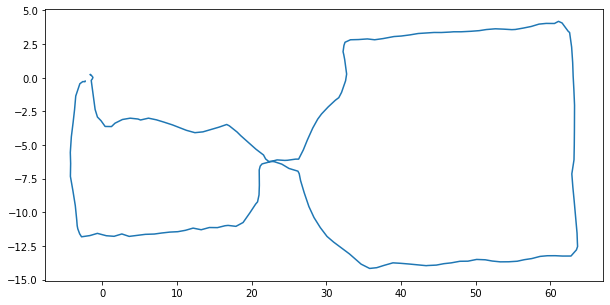

array([-1.59485840e+00,  2.42642721e-01,  5.29863265e-01,  7.11257591e-01,
        8.27321413e-03,  1.35203962e-02,  7.02752724e-01,  1.62823430e+18])

In [6]:
poses = est_trajectory[0]
permutation = [1, 2, 3, 4, 5, 6, 7, 0]    

a = poses[:, permutation]


f = plt.plot(a[:,0], a[:,1])
plt.show()
a[0,:]

INFO - 2021-10-19 16:26:31,383 - global_graph - [GlobalGraph] Initialized.
INFO - 2021-10-19 16:26:31,416 - global_graph - [GlobalGraph] Initialized.


Built 1 global and robot graphs.


/home/berlukas/.local/lib/python3.6/site-packages/PyGSP-0.5.1-py3.6.egg/pygsp/plotting.py:98: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=217, n_edges=2022)'}>)

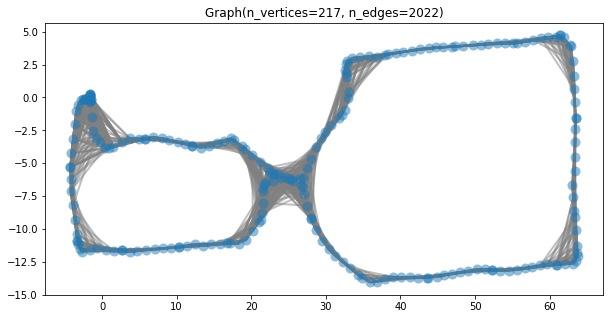

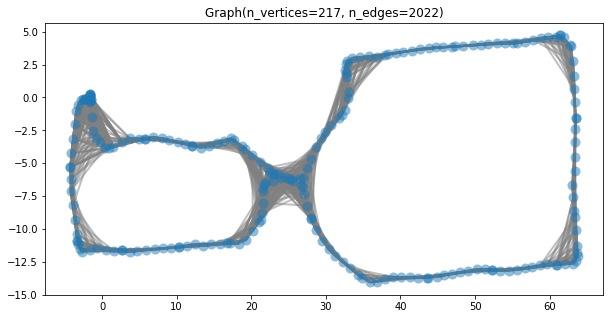

In [40]:
global_graph_per_dataset = []
robot_graph_per_dataset = []

client_config = DebugConfig()
for i in range(0, n_datasets):
    global_graph = GlobalGraph(client_config)
    global_graph.build_graph_from_coords_and_adj(opt_graph_coords[i], opt_graph_adj[i])    
    global_graph_per_dataset.append(global_graph)
    
    robot_graph = GlobalGraph(client_config)
    robot_graph.build_graph_from_coords_and_adj(est_graph_coords[i], est_graph_adj[i])    
    robot_graph_per_dataset.append(robot_graph)
    
    # rearange the columns s.t. the TS is at the end
#     poses = est_trajectory[i]
#     permutation = [1, 2, 3, 4, 5, 6, 7, 0]    
#     robot_graph.build_from_poses(poses[:, permutation])    
#     robot_graph_per_dataset.append(robot_graph)

n_graphs = len(global_graph_per_dataset)
assert n_graphs  == len(robot_graph_per_dataset)
print(f'Built {n_graphs} global and robot graphs.')

global_graph_per_dataset[0].G.plot()
robot_graph_per_dataset[0].G.plot()

In [15]:
i = 0
opt_origin = opt_trajectory[i][0,1:4]
est_origin = est_trajectory[i][0,1:4]

opt_pos_signal = (opt_trajectory[i][:,1:4] - opt_origin).squeeze()
est_pos_signal = (est_trajectory[i][:,1:4] - est_origin).squeeze()

x_opt = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_est = np.linalg.norm(est_pos_signal, ord=2, axis=1)

print(f'Global graph[{i}] opt dirichlet energy is {global_graph_per_dataset[0].G.dirichlet_energy(x_opt)}')
print(f'Global graph[{i}] est dirichlet energy is {global_graph_per_dataset[0].G.dirichlet_energy(x_est)}')
print(f'diff is {global_graph_per_dataset[0].G.dirichlet_energy(x_opt) - global_graph_per_dataset[0].G.dirichlet_energy(x_est)}')

Global graph[0] opt dirichlet energy is 3011.773351950341
Global graph[0] est dirichlet energy is 2970.3944022955056
diff is 41.378949654835196


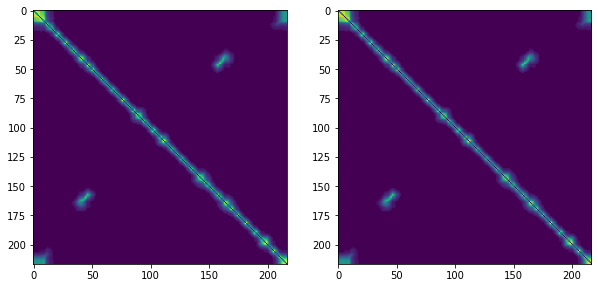

In [16]:
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1)
global_adj_plot = plt.imshow(global_graph_per_dataset[0].G.W.toarray())
plt.subplot(1, 2, 2)
robot_adj_plot = plt.imshow(robot_graph_per_dataset[0].G.W.toarray())

In [17]:
i = 0
global_graph_eval = WaveletEvaluator(7)
robot_graph_eval = WaveletEvaluator(7)
global_graph_eval.compute_wavelets(global_graph_per_dataset[i].G)
robot_graph_eval.compute_wavelets(robot_graph_per_dataset[i].G)

x_opt = opt_signals[i]
x_est = est_signals[i]
global_psi = global_graph_eval.get_wavelets()
robot_psi = robot_graph_eval.get_wavelets()
W_opt = global_graph_eval.compute_wavelet_coeffs(x_opt)
W_est = robot_graph_eval.compute_wavelet_coeffs(x_est)
assert W_opt.shape[0] == W_est.shape[0]
assert W_opt.shape[1] == W_est.shape[1]

INFO - 2021-10-19 07:49:37,984 - wavelet_evaluator - [WaveletEvaluator] Computing wavelets for 7 scales.
INFO - 2021-10-19 07:49:38,113 - wavelet_evaluator - [WaveletEvaluator] Computing wavelets for 7 scales.


In [18]:
n_nodes = global_psi.shape[0]
diff_low = np.array([0] * n_nodes)
diff_mid = np.array([0] * n_nodes)
diff_high = np.array([0] * n_nodes)
for i in range(n_nodes):    
    diff = global_psi[0,:,:] - robot_psi[i,:,:]
    diff_low[i] = np.mean(np.linalg.norm(diff[:,0:2], axis=1))
    diff_mid[i] = np.mean(np.linalg.norm(diff[:,2:5], axis=1))
    diff_high[i] = np.mean(np.linalg.norm(diff[:,5:8], axis=1))

diff_low = np.reshape(diff_low, (-1,1))
diff_mid = np.reshape(diff_mid, (-1,1))
diff_high = np.reshape(diff_high, (-1,1))

# fig, ax = plt.subplots(1, 2)
# plt.subplot(1, 2, 1)
# plt.imshow(global_psi[:,:,0])
# plt.subplot(1, 2, 2)
# plt.imshow(robot_psi[:,:,0])

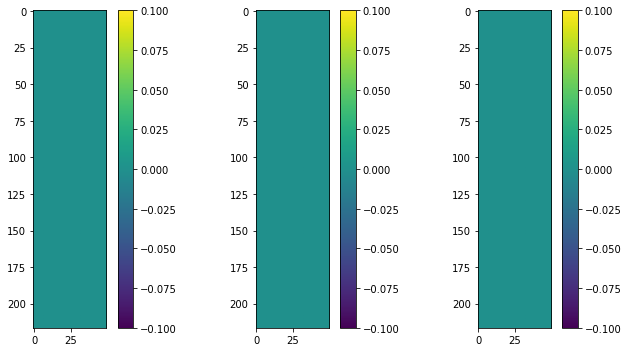

In [19]:
fig, ax = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
# difference_low = difference_low / np.max(difference_low)
diff_plot = plt.imshow(np.reshape(np.repeat(diff_low, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot)

# difference_mid = difference_mid / np.max(difference_mid)
plt.subplot(1, 3, 2)
diff_plot2 = plt.imshow(np.reshape(np.repeat(diff_mid, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot2)

plt.subplot(1, 3, 3)
diff_plot3 = plt.imshow(np.reshape(np.repeat(diff_high, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot3)
fig.tight_layout()

In [20]:
steps = [x*20 for x in range(50)]
n_nodes = W_opt.shape[0]

global_data = []
robot_data = []
for i in range(0, n_nodes):    
    global_wavelet_coefficients = [np.mean(np.exp(W_opt[i,:]*1.0*step*1j)) for step in steps]
    robot_wavelet_coefficients = [np.mean(np.exp(W_est[i,:]*1.0*step*1j)) for step in steps]
    global_data.append(global_wavelet_coefficients)
    robot_data.append(robot_wavelet_coefficients)

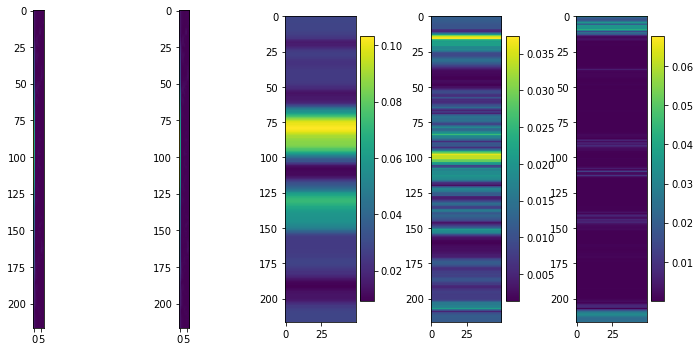

In [21]:
fig, ax = plt.subplots(1, 5)
plt.subplot(1, 5, 1)
# global_energy = np.abs(np.array(global_data))
# robot_energy = np.abs(np.array(robot_data))

global_energy = np.abs(np.array(W_opt))
robot_energy = np.abs(np.array(W_est))
plt.imshow(global_energy)
plt.subplot(1, 5, 2)
plt.imshow(robot_energy)

difference_low = np.linalg.norm(global_energy[:,0:2] - robot_energy[:,0:2], axis=1)
difference_low = np.reshape(difference_low, (-1,1))
# difference_low = difference_low / np.max(difference_low)
plt.subplot(1, 5, 3)
diff_plot = plt.imshow(np.reshape(np.repeat(difference_low, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot)

difference_mid = np.linalg.norm(global_energy[:,2:5] - robot_energy[:,2:5], axis=1)
difference_mid = np.reshape(difference_mid, (-1,1))
# difference_mid = difference_mid / np.max(difference_mid)
plt.subplot(1, 5, 4)
diff_plot2 = plt.imshow(np.reshape(np.repeat(difference_mid, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot2)

difference_high = np.linalg.norm(global_energy[:,5:8] - robot_energy[:,5:8], axis=1)
# difference_high = difference_high / np.max(difference_high)
difference_high = np.reshape(difference_high, (-1,1))
plt.subplot(1, 5, 5)
diff_plot3 = plt.imshow(np.reshape(np.repeat(difference_high, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot3)
fig.tight_layout()

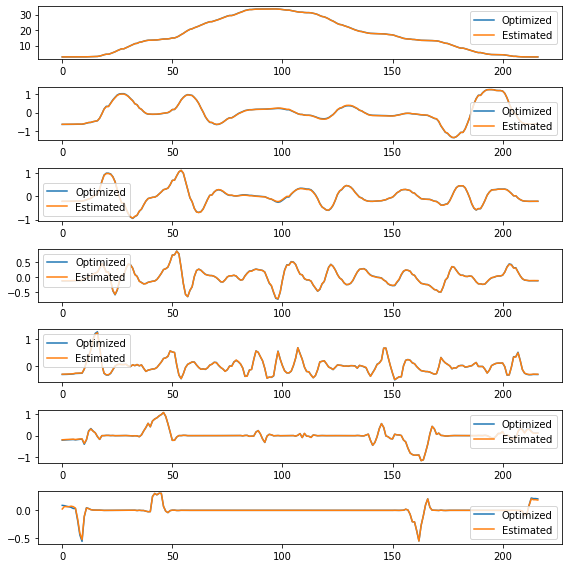

In [22]:
fig, axes = plt.subplots(7, 1, figsize=(8, 8))
#fig.subplots_adjust(hspace=0.5)

for i in range(0, 7):
    axes[i].plot(W_opt[:,i], label='Optimized')
    axes[i].plot(W_est[:,i], label='Estimated')    
    axes[i].legend()
plt.tight_layout()

/home/berlukas/.local/lib/python3.6/site-packages/PyGSP-0.5.1-py3.6.egg/pygsp/plotting.py:98: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


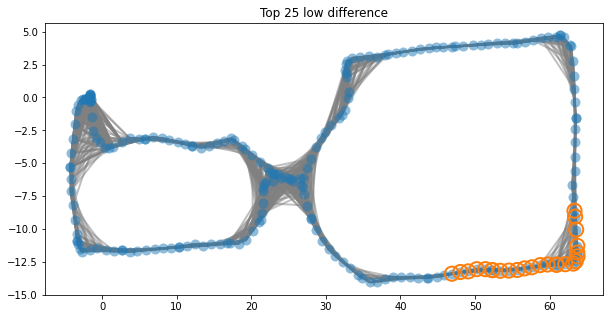

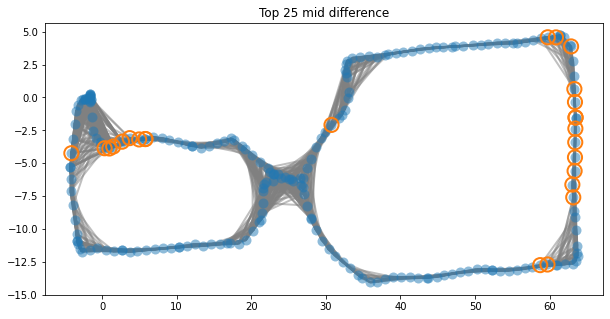

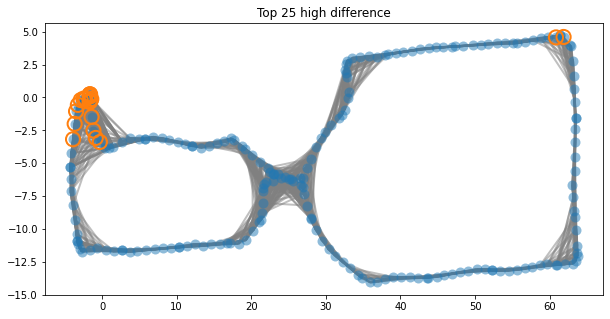

In [23]:
top_n = 25

ind = np.unravel_index(np.argsort(difference_low, axis=None), difference_low.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} low difference', highlight=peaks)

ind = np.unravel_index(np.argsort(difference_mid, axis=None), difference_mid.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} mid difference', highlight=peaks)

ind = np.unravel_index(np.argsort(difference_high, axis=None), difference_high.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} high difference', highlight=peaks)

## Baseline Solution (Simple distance-based)

Synced signal shapes are (217, 8) and (217, 8)


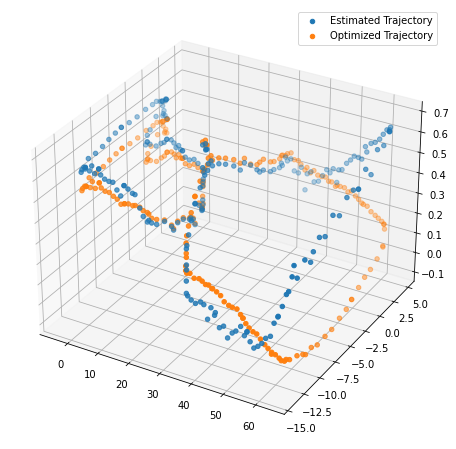

In [31]:
def compare_trajectories(est_traj, opt_traj):    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(est_traj[:,1], est_traj[:,2], est_traj[:,3], label='Estimated Trajectory')
    ax.scatter(opt_traj[:,1], opt_traj[:,2], opt_traj[:,3], label='Optimized Trajectory')
    plt.legend()
    plt.show()
    
i = 0
print(f'Synced signal shapes are {est_trajectory[i].shape} and {opt_trajectory[i].shape}')
compare_trajectories(est_trajectory[i], opt_trajectory[i])

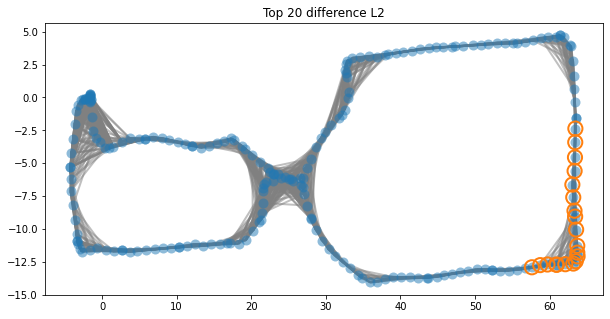

In [32]:
top_n = 20
diff_simple = np.linalg.norm(est_trajectory[i][:,1:4] - opt_trajectory[i][:,1:4], axis=1)
ind = np.unravel_index(np.argsort(diff_simple, axis=None), diff_simple.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title='Top 20 difference L2', highlight=peaks)

In [33]:
n_nodes = opt_trajectory[0].shape[0]
x_opt_rot = [0] * n_nodes
x_est_rot = [0] * n_nodes

wxyz = opt_trajectory[0][i,4:8]
opt_origin = Rotation.from_quat([wxyz[1], wxyz[2], wxyz[3], wxyz[0]]).as_matrix()

wxyz = est_trajectory[0][i,4:8]
est_origin = Rotation.from_quat([wxyz[1], wxyz[2], wxyz[3], wxyz[0]]).as_matrix()


for i in range(0, n_nodes):
    wxyz = opt_trajectory[0][i,4:8]
    rot_diff = np.matmul(opt_origin, Rotation.from_quat([wxyz[1], wxyz[2], wxyz[3], wxyz[0]]).as_matrix().transpose())
#     x_opt_rot[i] = np.nan_to_num(np.arccos(0.5 * (np.trace(rot_diff)-1)))
    x_opt_rot[i] = np.trace(rot_diff)

    wxyz = est_trajectory[0][i,4:8]
    rot_diff = np.matmul(est_origin, Rotation.from_quat([wxyz[1], wxyz[2], wxyz[3], wxyz[0]]).as_matrix().transpose())
#     x_est_rot[i] = np.nan_to_num(np.arccos(0.5 * (np.trace(rot_diff)-1)))
    x_est_rot[i] = np.trace(rot_diff)

                                  
x_opt_rot = np.array(x_opt_rot)
x_est_rot = np.array(x_est_rot)

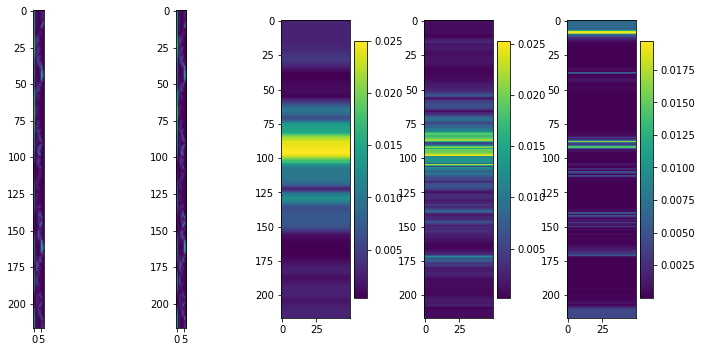

In [34]:
W_opt = global_graph_eval.compute_wavelet_coeffs(x_opt_rot)
W_est = robot_graph_eval.compute_wavelet_coeffs(x_est_rot)

fig, ax = plt.subplots(1, 5)
plt.subplot(1, 5, 1)
global_energy = np.abs(np.array(W_opt))
robot_energy = np.abs(np.array(W_est))

plt.imshow(global_energy)
plt.subplot(1, 5, 2)
plt.imshow(robot_energy)

difference_low = np.linalg.norm(global_energy[:,0:2] - robot_energy[:,0:2], axis=1)
difference_low = np.reshape(difference_low, (-1,1))
# difference_low = difference_low / np.max(difference_low)
plt.subplot(1, 5, 3)
diff_plot = plt.imshow(np.reshape(np.repeat(difference_low, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot)

difference_mid = np.linalg.norm(global_energy[:,2:5] - robot_energy[:,2:5], axis=1)
difference_mid = np.reshape(difference_mid, (-1,1))
# difference_mid = difference_mid / np.max(difference_mid)
plt.subplot(1, 5, 4)
diff_plot2 = plt.imshow(np.reshape(np.repeat(difference_mid, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot2)

difference_high = np.linalg.norm(global_energy[:,5:8] - robot_energy[:,5:8], axis=1)
# difference_high = difference_high / np.max(difference_high)
difference_high = np.reshape(difference_high, (-1,1))
plt.subplot(1, 5, 5)
diff_plot3 = plt.imshow(np.reshape(np.repeat(difference_high, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot3)
fig.tight_layout()

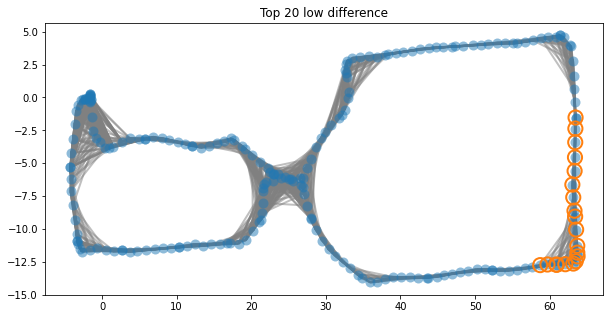

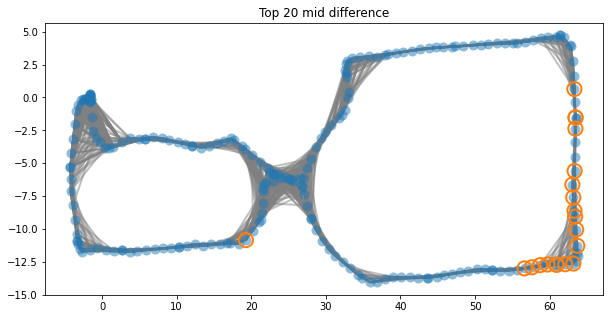

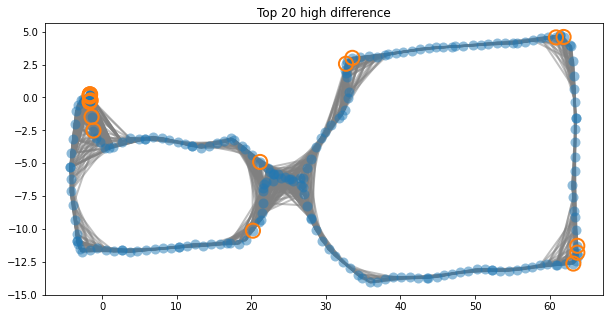

In [35]:
top_n = 20

ind = np.unravel_index(np.argsort(difference_low, axis=None), difference_low.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} low difference', highlight=peaks)

ind = np.unravel_index(np.argsort(difference_mid, axis=None), difference_mid.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} mid difference', highlight=peaks)

ind = np.unravel_index(np.argsort(difference_high, axis=None), difference_high.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} high difference', highlight=peaks)

energy shape is (217,)


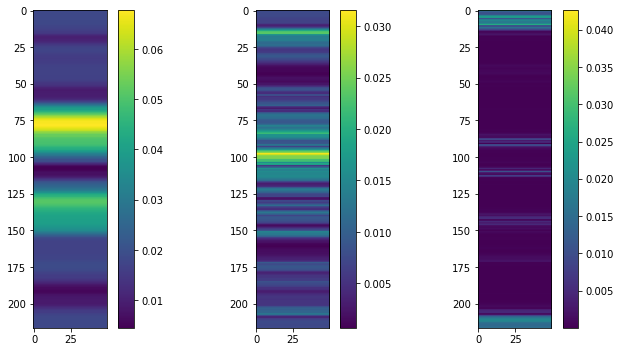

In [36]:
### Combined

x_opt_combined = np.column_stack((x_opt, x_opt_rot))
x_est_combined = np.column_stack((x_est, x_est_rot))
W_opt = global_graph_eval.compute_wavelet_coeffs(x_opt_combined)
W_est = robot_graph_eval.compute_wavelet_coeffs(x_est_combined)
global_energy = np.abs(np.array(W_opt))
robot_energy = np.abs(np.array(W_est))

diff = global_energy[:,0:2] - robot_energy[:,0:2]
diff_n = np.linalg.norm(diff, axis=1)
print(f'energy shape is {diff_n.shape}')

fig, ax = plt.subplots(1, 3)
difference_low = np.linalg.norm(global_energy[:,0:2] - robot_energy[:,0:2], axis=1)
# difference_low = np.reshape(difference_low, (-1,1))
# difference_low = difference_low / np.max(difference_low)
# difference_low = np.sum(difference_low, axis=1)
plt.subplot(1, 3, 1)
diff_plot = plt.imshow(np.reshape(np.repeat(difference_low, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot)

difference_mid = np.linalg.norm(global_energy[:,2:5] - robot_energy[:,2:5], axis=1)
# difference_mid = np.reshape(difference_mid, (-1,1))
# difference_mid = difference_mid / np.max(difference_mid)
# difference_mid = np.sum(difference_mid, axis=1)
plt.subplot(1, 3, 2)
diff_plot2 = plt.imshow(np.reshape(np.repeat(difference_mid, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot2)

difference_high = np.linalg.norm(global_energy[:,5:8] - robot_energy[:,5:8], axis=1)
# difference_high = difference_high / np.max(difference_high)
# difference_high = np.reshape(difference_high, (-1,1))
# difference_high = np.sum(difference_high, axis=1)
plt.subplot(1, 3, 3)
diff_plot3 = plt.imshow(np.reshape(np.repeat(difference_high, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot3)
fig.tight_layout()

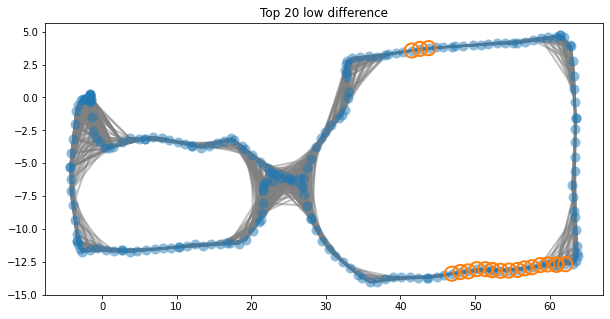

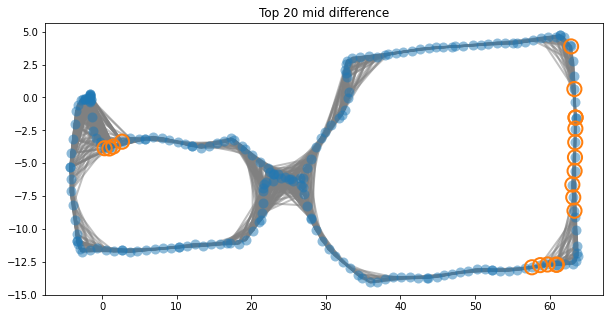

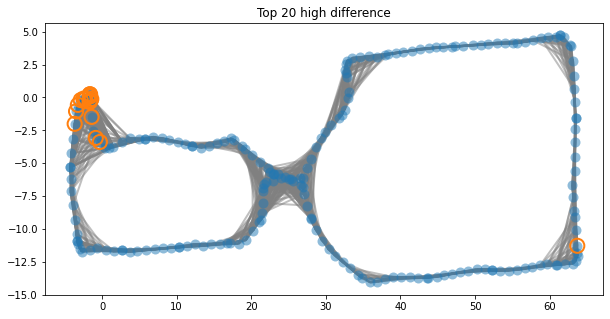

In [37]:
top_n = 20

ind = np.unravel_index(np.argsort(difference_low, axis=None), difference_low.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} low difference', highlight=peaks)

ind = np.unravel_index(np.argsort(difference_mid, axis=None), difference_mid.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} mid difference', highlight=peaks)

ind = np.unravel_index(np.argsort(difference_high, axis=None), difference_high.shape)
peaks = ind[0][-top_n:][::-1]
_ = global_graph_per_dataset[0].G.plot(title=f'Top {top_n} high difference', highlight=peaks)

In [53]:
g = global_graph_per_dataset[0]
ev = np.abs(g.G.U)
for i in range(0, 100):
    idx = np.argmax(ev)
    idx_vertex, idx_fourier = np.unravel_index(idx, g.G.U.shape)
    print(f'EV({idx_vertex},{idx_fourier}) is {ev[idx_vertex, idx_fourier]}')
    ev[idx_vertex, :] = -1    

EV(10,200) is 0.8896235756560807
EV(5,216) is 0.8692526644408768
EV(209,177) is 0.8526464336203582
EV(197,171) is 0.8409954384497366
EV(204,135) is 0.8187727193991436
EV(15,166) is 0.8185171389592536
EV(142,168) is 0.816801967189618
EV(144,173) is 0.8152250623637617
EV(8,215) is 0.8107656710199329
EV(11,185) is 0.805101081029179
EV(140,149) is 0.8035729542617159
EV(17,130) is 0.8033974579426207
EV(16,158) is 0.8021396731744016
EV(87,138) is 0.7980308952756285
EV(213,205) is 0.7929837280075318
EV(7,214) is 0.7900281264451502
EV(89,154) is 0.7900023692748797
EV(194,139) is 0.7888817412534479
EV(208,161) is 0.7779347345221556
EV(34,124) is 0.7714181572641496
EV(94,134) is 0.7683932172923514
EV(216,206) is 0.7608872279850213
EV(191,107) is 0.7599803586452029
EV(118,95) is 0.7543904920776567
EV(49,165) is 0.7531759144134536
EV(139,128) is 0.7526506481149171
EV(195,153) is 0.7459426119714455
EV(153,132) is 0.7450124172647277
EV(84,115) is 0.743400017377937
EV(170,169) is 0.7428611750500929
E